In [1]:
# =====================================================
# BLOQUE 1: Importar librerías necesarias
# =====================================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from joblib import dump
import cv2

from skimage import io, color, exposure
from skimage.transform import resize
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [2]:
# =====================================================
# BLOQUE 2: Definición de parámetros
# =====================================================

# Parámetros para extracción HOG
HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    visualize=False,
    transform_sqrt=True
)

# Ruta del dataset
EXTRACT_DIR = "/content/drive/MyDrive/Maestría Eafit/3er Semestre/Visión por computador/Talleres/data/mango_leaf_disease/mango_leaf_disease"

# Tamaño al que se redimensionarán las imágenes
IMG_SIZE = (128, 128)

In [3]:
# =====================================================
# BLOQUE 3: Función para leer imágenes y extraer HOG
# =====================================================

def leer_imagenes(base_dir):
    """
    Lee imágenes desde subcarpetas dentro del directorio base y genera
    matrices de características y etiquetas. Ignora archivos no válidos
    o imágenes corruptas.

    Args:
        base_dir (str): Ruta base donde cada subcarpeta representa una clase.

    Returns:
        X (np.ndarray): Características de imágenes.
        y (np.ndarray): Etiquetas correspondientes.
    """
    clases = [c for c in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, c))]
    print(f"📁 Clases detectadas: {clases}")

    X, y = [], []

    for etiqueta in tqdm(clases, desc="Leyendo imágenes por clase"):
        carpeta = os.path.join(base_dir, etiqueta)
        for archivo in os.listdir(carpeta):
            ruta = os.path.join(carpeta, archivo)

            # Validar formato
            if not archivo.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Leer imagen
            img = cv2.imread(ruta)
            if img is None:
                print(f"⚠️ Error leyendo {ruta}: archivo corrupto o formato no soportado.")
                continue

            try:
                img = cv2.resize(img, (128, 128))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                X.append(gray.flatten())
                y.append(etiqueta)
            except Exception as e:
                print(f"⚠️ Error procesando {ruta}: {e}")
                continue

    print(f"✅ Total de imágenes procesadas: {len(X)}")
    return np.array(X), np.array(y)


In [4]:
# =====================================================
# BLOQUE 4: Cargar imágenes y guardar HOG features
# =====================================================

X, y = leer_imagenes(EXTRACT_DIR)
np.savez("hog_features_mango.npz", X=X, y=y)

print(f"✅ Total de imágenes procesadas: {len(X)}")
print(f"📊 Clases detectadas: {set(y)}")


📁 Clases detectadas: ['Bacterial Canker', 'Anthracnose', 'Cutting Weevil', 'Die Back', 'Healthy', 'Gall Midge', 'Sooty Mould', 'Powdery Mildew']


Leyendo imágenes por clase: 100%|██████████| 8/8 [01:41<00:00, 12.66s/it]

✅ Total de imágenes procesadas: 4000
✅ Total de imágenes procesadas: 4000
📊 Clases detectadas: {np.str_('Sooty Mould'), np.str_('Bacterial Canker'), np.str_('Die Back'), np.str_('Anthracnose'), np.str_('Powdery Mildew'), np.str_('Healthy'), np.str_('Cutting Weevil'), np.str_('Gall Midge')}


/tmp/ipython-input-84914934.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x='Clase', y='Cantidad', palette="viridis")


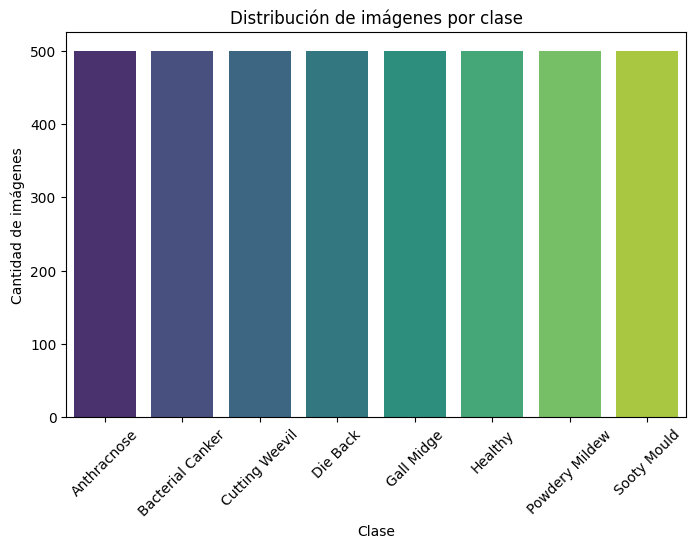

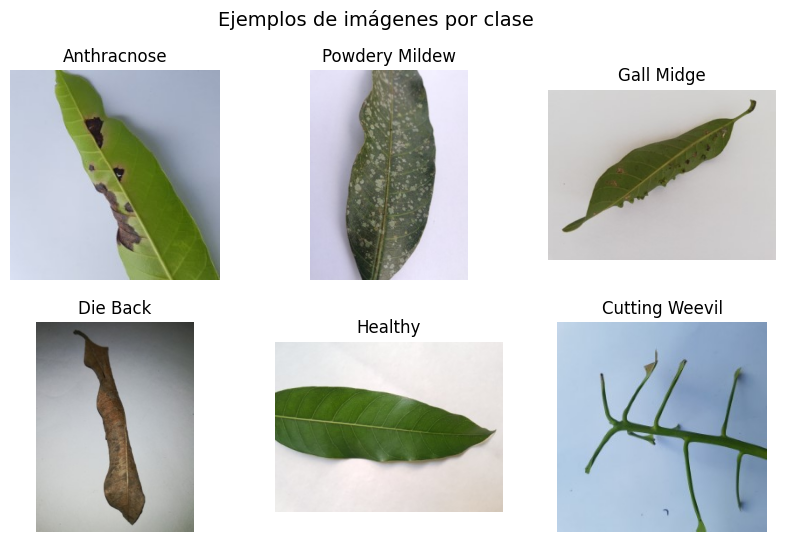

In [5]:
# =====================================================
# BLOQUE 5: EDA básico sobre el dataset
# =====================================================

import pandas as pd
# Conteo de imágenes por clase
unique, counts = np.unique(y, return_counts=True)
df_counts = pd.DataFrame({'Clase': unique, 'Cantidad': counts})
plt.figure(figsize=(8, 5))
sns.barplot(data=df_counts, x='Clase', y='Cantidad', palette="viridis")
plt.title("Distribución de imágenes por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.xticks(rotation=45)
plt.show()

# Mostrar algunas imágenes aleatorias
plt.figure(figsize=(10, 6))
for i, clase in enumerate(random.sample(list(set(y)), min(6, len(set(y))))):
    carpeta = os.path.join(EXTRACT_DIR, clase)
    archivo = random.choice(os.listdir(carpeta))
    img = io.imread(os.path.join(carpeta, archivo))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(clase)
    plt.axis("off")
plt.suptitle("Ejemplos de imágenes por clase", fontsize=14)
plt.show()


In [6]:
# =====================================================
# BLOQUE 6: División de datos y entrenamiento SVM
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

# Guardar modelo
dump(clf, "modelo_svm_mango.joblib")
print("✅ Modelo SVM guardado como 'modelo_svm_mango.joblib'")

✅ Modelo SVM guardado como 'modelo_svm_mango.joblib'


In [7]:
# =====================================================
# BLOQUE 7: Evaluación del modelo
# =====================================================

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("\n📈 RESULTADOS DEL MODELO")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



📈 RESULTADOS DEL MODELO
Accuracy: 0.5400
F1-Score: 0.5353

Reporte de clasificación:
                  precision    recall  f1-score   support

     Anthracnose       0.48      0.57      0.52       100
Bacterial Canker       0.62      0.63      0.62       100
  Cutting Weevil       0.89      0.92      0.91       100
        Die Back       0.62      0.63      0.63       100
      Gall Midge       0.32      0.30      0.31       100
         Healthy       0.48      0.55      0.51       100
  Powdery Mildew       0.49      0.43      0.46       100
     Sooty Mould       0.36      0.29      0.32       100

        accuracy                           0.54       800
       macro avg       0.53      0.54      0.54       800
    weighted avg       0.53      0.54      0.54       800



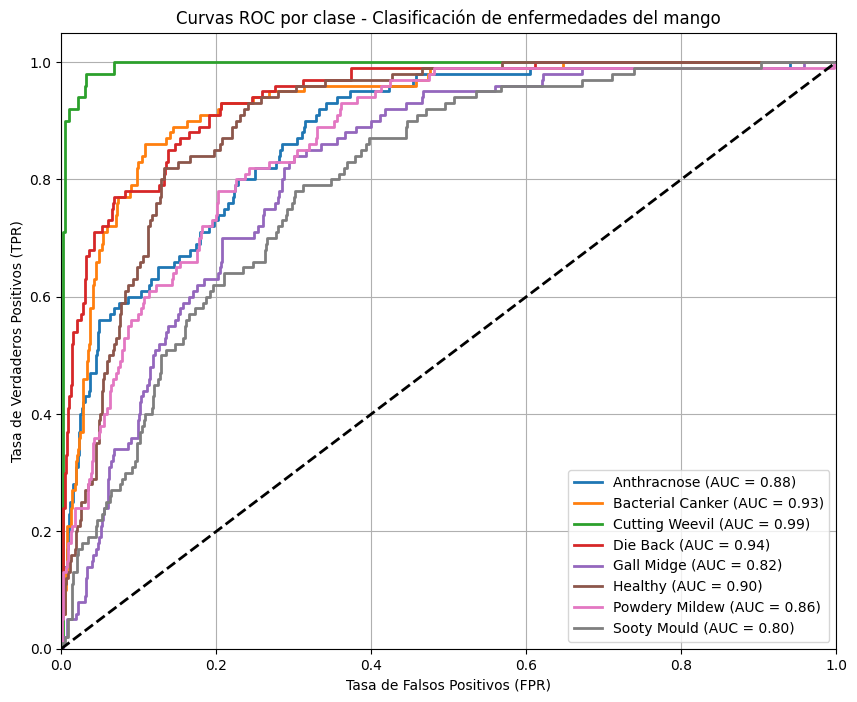

In [8]:
# =====================================================
# BLOQUE 8: Curvas ROC y AUC por clase
# =====================================================

y_score = clf.predict_proba(X_test)
clases = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=clases)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(clases)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = cycle(plt.cm.tab10.colors)
for i, color in zip(range(len(clases)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{clases[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC por clase - Clasificación de enfermedades del mango")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
